Długość tekstu: 244
Rozmiar słownika: 26
Liczba wzorców treningowych: 224

Trening
Epoka 0/3000, Loss: 3.2447
Osiągnięto cel! Epoka 66, Loss: 0.0938

Test generowania
Ziarno: 'In the first decades'
Wygenerowano:
In the first decades of the 21st century, highly mathematical and statistical machine learning has dominated the field, and this technique has proved highly successful, helping to solve many challenging problems througho


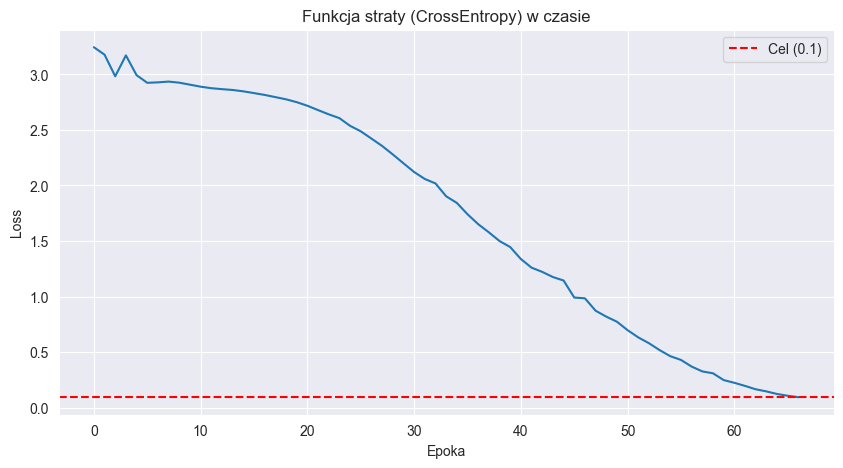

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# KONFIGURACJA
text = "In the first decades of the 21st century, highly mathematical and statistical machine learning has dominated the field, and this technique has proved highly successful, helping to solve many challenging problems throughout industry and academia"

# Hiperparametry
SEQ_LEN = 20        # Długość sekwencji wejściowej
HIDDEN_SIZE = 128   # Liczba neuronów w warstwie ukrytej LSTM
NUM_LAYERS = 1      # Liczba warstw LSTM
LEARNING_RATE = 0.01
EPOCHS = 3000       # Maksymalna liczba epok
TARGET_LOSS = 0.1   # Cel zadania

# PRZETWARZANIE DANYCH

# Tworzenie słownika znaków
chars = sorted(list(set(text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

vocab_size = len(chars)
data_len = len(text)

print(f"Długość tekstu: {data_len}")
print(f"Rozmiar słownika: {vocab_size}")

# Tworzenie datasetu (okno przesuwne)
inputs = []
targets = []

for i in range(0, data_len - SEQ_LEN):
    seq_in = text[i : i + SEQ_LEN]
    seq_out = text[i + SEQ_LEN]
    inputs.append([char_to_int[char] for char in seq_in])
    targets.append(char_to_int[seq_out])

n_patterns = len(inputs)
print(f"Liczba wzorców treningowych: {n_patterns}")

# Konwersja na tensory
# X: [batch_size, seq_len, vocab_size] (One-Hot Encoding)
X = torch.zeros((n_patterns, SEQ_LEN, vocab_size), dtype=torch.float32)
for i, seq in enumerate(inputs):
    for j, char_idx in enumerate(seq):
        X[i, j, char_idx] = 1

# y: [batch_size] (Indices)
y = torch.tensor(targets, dtype=torch.long)

# MODEL LSTM

class TextLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(TextLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Warstwa LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Warstwa w pełni połączona (wyjście)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Inicjalizacja stanów ukrytych (h0, c0) zerami
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Propagacja przez LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Bierzemy wyjście z ostatniego kroku czasowego
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = TextLSTM(vocab_size, HIDDEN_SIZE, vocab_size, NUM_LAYERS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TRENING
loss_history = []
print("\nTrening")

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()

    output = model(X)
    loss = criterion(output, y)

    loss.backward()
    optimizer.step()

    loss_val = loss.item()
    loss_history.append(loss_val)

    if epoch % 100 == 0:
        print(f"Epoka {epoch}/{EPOCHS}, Loss: {loss_val:.4f}")

    # Warunek stopu
    if loss_val < TARGET_LOSS:
        print(f"Osiągnięto cel! Epoka {epoch}, Loss: {loss_val:.4f}")
        break

# GENEROWANIE TEKSTU
model.eval()
print("\nTest generowania")

# Startujemy od początku oryginalnego tekstu
start_idx = 0
seed_text = text[start_idx : start_idx + SEQ_LEN]
generated_text = seed_text
current_seq_idxs = [char_to_int[c] for c in seed_text]

print(f"Ziarno: '{seed_text}'")

for i in range(200): # Generujemy 200 znaków
    # Przygotowanie inputu one-hot
    x_input = torch.zeros((1, SEQ_LEN, vocab_size))
    for t, char_idx in enumerate(current_seq_idxs):
        x_input[0, t, char_idx] = 1

    with torch.no_grad():
        prediction = model(x_input)

    # Wybór znaku o najwyższym prawdopodobieństwie
    predicted_idx = torch.argmax(prediction, dim=1).item()
    predicted_char = int_to_char[predicted_idx]

    generated_text += predicted_char

    # Przesunięcie okna
    current_seq_idxs.append(predicted_idx)
    current_seq_idxs = current_seq_idxs[1:]

print(f"Wygenerowano:\n{generated_text}")

# WYKRES
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.axhline(y=TARGET_LOSS, color='r', linestyle='--', label='Cel (0.1)')
plt.title("Funkcja straty (CrossEntropy) w czasie")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.show()